# Experimentos

Notebook com o propósito de compreender o porque de NONE UDLF Non-Local Means possuir métricas melhores que o Non-Local Means e melhores que UDLF Non-Local Means de outros métodos (como CPRR, LHRR e RL-RECOM).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

import os
import sys

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

from utils import *
from parameters import *

# Function related imports
from nlmeans.fourier_center import fourier_center
from pyUDLF import run_calls as udlf
from pyUDLF.utils import inputType

## Non-Local Means

In [2]:
def nlmeans(ima_nse, hW, hP, tau, sig, shape):
    DIFF = []
    DIFF_PATCH = []
    IMG_SHIFT = []
    WEIGHT = []
    WEIGHT_ID = []

    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Main loop
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue
            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            diff = (ima_nse - ima_nse[x_idx, y_idx])**2

            # DEBUG
            DIFF.append(diff)
            IMG_SHIFT.append(ima_nse[x_idx, y_idx])

            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)
            w_id = np.ravel_multi_index([x_idx, y_idx], (M, N))

            # DEBUG
            DIFF_PATCH.append(diff)
            WEIGHT.append(w)
            WEIGHT_ID.append(w_id)

            # Increment accumulators for the weighted average
            sum_w += w
            sum_wI += w * ima_nse[x_idx, y_idx]

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    sum_w += np.exp(-2*sig**2/tau**2)
    sum_wI += np.exp(-2*sig**2/tau**2) * ima_nse

    # DEBUG
    DIFF.append(np.zeros((M, N)))
    DIFF_PATCH.append(np.zeros((M, N)))
    WEIGHT.append(np.zeros((M, N)) + np.exp(-2*sig**2/tau**2))
    WEIGHT_ID.append(np.arange(40000).reshape(M, N))

    # Weighted average
    ima_fil = sum_wI / sum_w
    # ima_w = w / sum_w

    return ima_fil, DIFF, DIFF_PATCH, WEIGHT, WEIGHT_ID, IMG_SHIFT

## UDLF Non-Local Means config
Função auxiliar para criar um objeto de configuração utilizado pelo pyUDLF.

In [3]:
def udlf_config(size_dataset, L, udl_method, udl_params):
    # Set the paths for UDLF
    udlf.setBinaryPath('udlf/udlf')
    udlf.setConfigPath('udlf/config.ini')

    # Set UDLF configuration options properly
    input_data = inputType.InputType()

    # Input dataset files
    input_data.set_param('UDL_TASK', 'UDL')
    input_data.set_param('UDL_METHOD', f'{udl_method}')
    input_data.set_param('SIZE_DATASET', f'{size_dataset}')
    input_data.set_param('INPUT_FILE_FORMAT', 'RK')
    input_data.set_param('INPUT_RK_FORMAT', 'NUM')
    input_data.set_param('INPUT_FILE', 'input.txt')
    input_data.set_param('INPUT_FILE_LIST', 'list.txt')

    # Output file settings
    input_data.set_param('OUTPUT_FILE', 'TRUE')
    input_data.set_param('OUTPUT_FILE_FORMAT', 'RK')
    input_data.set_param('OUTPUT_RK_FORMAT', 'NUM')
    input_data.set_param('OUTPUT_FILE_PATH', 'output')

    # Evaluation settings
    input_data.set_param('EFFECTIVENESS_EVAL', 'FALSE')

    # Method parameters
    if(udl_method == 'NONE'):
        input_data.set_param('PARAM_NONE_L', f'{L}')

    elif(udl_method == 'CPRR'):
        input_data.set_param('PARAM_CPRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CPRR_L', f'{L}')
        input_data.set_param('PARAM_CPRR_T', f'{udl_params["t"]}')

    elif(udl_method == 'RLRECOM'):
        input_data.set_param('PARAM_RLRECOM_L', f'{L}')
        input_data.set_param('PARAM_RLRECOM_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RLRECOM_LAMBDA', f'{udl_params["lambda"]}')
        input_data.set_param('PARAM_RLRECOM_EPSILON', f'{udl_params["epsilon"]}')

    elif(udl_method == 'RLSIM'):
        input_data.set_param('PARAM_RLSIM_TOPK', f'{udl_params["topk"]}')
        input_data.set_param('PARAM_RLSIM_CK', f'{L}')
        input_data.set_param('PARAM_RLSIM_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RLSIM_METRIC', f'{udl_params["metric"]}')

    elif(udl_method == 'CONTEXTRR'):
        input_data.set_param('PARAM_CONTEXTRR_L', f'{udl_params["l"]}')
        input_data.set_param('PARAM_CONTEXTRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CONTEXTRR_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_CONTEXTRR_NBYK', f'{udl_params["nbyk"]}')
        input_data.set_param('PARAM_CONTEXTRR_OPTIMIZATIONS', f'{udl_params["opt"]}')

    elif(udl_method == 'RECKNNGRAPH'):
        input_data.set_param('PARAM_RECKNNGRAPH_L', f'{L}')
        input_data.set_param('PARAM_RECKNNGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RECKNNGRAPH_EPSILON', f'{udl_params["epsilon"]}')

    elif(udl_method == 'RKGRAPH'):
        input_data.set_param('PARAM_RKGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RKGRAPH_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RKGRAPH_P', f'{udl_params["p"]}')
        input_data.set_param('PARAM_RKGRAPH_L', f'{L}')

    elif(udl_method == 'CORGRAPH'):
        input_data.set_param('PARAM_CORGRAPH_L', f'{L}')
        input_data.set_param('PARAM_CORGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_START', f'{udl_params["thold_s"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_END', f'{udl_params["thold_e"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_INC', f'{udl_params["thold_i"]}')
        input_data.set_param('PARAM_CORGRAPH_CORRELATION', f'{udl_params["corr"]}')

    elif(udl_method == 'LHRR'):
        input_data.set_param('PARAM_LHRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_LHRR_L', f'{L}')
        input_data.set_param('PARAM_LHRR_T', f'{udl_params["t"]}')

    elif(udl_method == 'BFSTREE'):
        input_data.set_param('PARAM_BFSTREE_L', f'{L}')
        input_data.set_param('PARAM_BFSTREE_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_BFSTREE_CORRELATION_METRIC', f'{udl_params["corr"]}')

    elif(udl_method == 'RDPAC'):
        input_data.set_param('PARAM_RDPAC_K_END', f'{udl_params["k_e"]}')
        input_data.set_param('PARAM_RDPAC_K_INC', f'{udl_params["k_i"]}')
        input_data.set_param('PARAM_RDPAC_K_START', f'{udl_params["k_s"]}')
        input_data.set_param('PARAM_RDPAC_L', f'{L}')
        input_data.set_param('PARAM_RDPAC_L_MULT', f'{udl_params["l_mult"]}')
        input_data.set_param('PARAM_RDPAC_P', f'{udl_params["p"]}')
        input_data.set_param('PARAM_RDPAC_PL', f'{udl_params["pl"]}')

    elif(udl_method == 'RFE'):
        input_data.set_param('PARAM_RFE_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RFE_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RFE_L', f'{L}')
        input_data.set_param('PARAM_RFE_PA', f'{udl_params["pa"]}')
        input_data.set_param('PARAM_RFE_TH_CC', f'{udl_params["th_cc"]}')
        input_data.set_param('PARAM_RFE_RERANK_BY_EMB', f'{udl_params["rr_by_emb"]}')
        input_data.set_param('PARAM_RFE_EXPORT_EMBEDDINGS', f'{udl_params["emb_exp"]}')
        input_data.set_param('PARAM_RFE_PERFORM_CSS', f'{udl_params["css"]}')
        input_data.set_param('PARAM_RFE_EMBEDDINGS_PATH', f'{udl_params["emb_path"]}')
        input_data.set_param('PARAM_RFE_CCS_PATH', f'{udl_params["css_path"]}')

    return input_data

## UDLF Non-Local Means

Função alterada do UDLF Non-Local Means com o objetivo de armazenar dados relevantes para o entendimento do comportamento do programa.

In [4]:
def nlmeans_udlf(ima_nse, hW, hP, tau, sig, shape, udl_method, udl_params, n_w):
    DIFF = []
    DIFF_UDLF = []
    DIFF_PATCH = []
    DIFF_PATCH_UDLF = []
    WEIGHT = []
    WEIGHT_ID = []
    WEIGHT_UDLF = []
    WEIGHT_ID_UDLF = []
    SHIFT_IMG_NLM = []
    SHIFT_IMG_UDLF = []

    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Weight value and weight names matrices
    w_values = []
    w_names = []

    # Main loop
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue

            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            diff = (ima_nse - ima_nse[x_idx, y_idx])**2

            # DEBUG
            DIFF.append(diff)
            SHIFT_IMG_NLM.append(ima_nse[x_idx, y_idx])

            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))
            
            # DEBUG
            DIFF_PATCH.append(diff)

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)
            w_id = np.ravel_multi_index([x_idx, y_idx], (M, N))

            # Save the weight matrix and its identifiers
            w_values.append(w)
            w_names.append(w_id)

            # DEGUG
            WEIGHT.append(w)
            WEIGHT_ID.append(w_id)

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    w_values.append(np.zeros((M, N)) + np.exp(-2*sig**2/tau**2))
    w_names.append(np.arange(M * N).reshape(M, N))
    
    # DEBUG
    DIFF.append(np.zeros((M, N))) # Diff between the original image and unshifted image is 0
    DIFF_PATCH.append(np.zeros((M, N))) 
    WEIGHT.append((np.zeros((M, N)) + np.exp(-2*sig**2/tau**2)))
    WEIGHT_ID.append((np.arange(M * N).reshape(M, N)))

    # Transform the python lists of matrices into a 3D numpy array
    w_values = np.stack(w_values, axis=-1)
    w_names = np.stack(w_names, axis=-1).astype(int)
    NEIGHBOURHOOD_SIZE = w_values.shape[2]

    # Create the ranked list of weight matrices for udlf
    ranked_lists = np.zeros((M * N, NEIGHBOURHOOD_SIZE), dtype=int)
    for i in range(M):
        for j in range(N):
            rl = np.rec.fromarrays((w_names[i, j, :], w_values[i, j, :]),
                                   names=('names', 'values'))
            rl = rl[rl['values'].argsort()]
            ranked_lists[i * M + j, :] = np.copy(rl['names'])

    # Create the input file for the UDLF
    np.savetxt('input.txt', ranked_lists, fmt='%d', delimiter=' ', newline='\n')

    # Creation of the weight names list
    weight_names_list = np.reshape(np.arange(0, M * N, dtype=int), (M * N, 1))
    np.savetxt('list.txt', weight_names_list, fmt='%d', delimiter=' ', newline='\n')

    # UDLF configuration
    input_data = udlf_config(
        size_dataset = M*N,
        L = NEIGHBOURHOOD_SIZE,
        udl_method = udl_method,
        udl_params = udl_params
    )

    if not udl_method == 'NONE':
        # Run the UDLF framework to get a ranked list of weights
        udlf.run(input_data, get_output=True)
        new_ranked_lists = np.loadtxt('output.txt',
                                      dtype=int,
                                      delimiter=' ',
                                      usecols=range(ranked_lists.shape[1]))
    else:
        new_ranked_lists = ranked_lists
        
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    if n_w is None or n_w > NEIGHBOURHOOD_SIZE:
        n_w = new_ranked_lists.shape[1]

    for col in range(n_w):
        # Get the `num_weights` first elements of the ranked list array at `pos`
        new_w_names = new_ranked_lists[:, col].reshape(M, N)

        # Get the image coordinates giving the ranked list values
        x_idx, y_idx = np.unravel_index(new_w_names, (M, N))

        # Calculate the Euclidean distance between all pairs of
        # patches in the direction (dx, dy)
        diff = (ima_nse - ima_nse[x_idx, y_idx])**2

        # DEBUG
        DIFF_UDLF.append(diff)
        SHIFT_IMG_UDLF.append(ima_nse[x_idx, y_idx])

        diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))

        # DEBUG
        DIFF_PATCH_UDLF.append(diff)

        # Convert the distance to weights using an exponential
        # kernel (this is a critical step!)
        if (diff == 0).all():
            w = np.zeros((M, N)) + np.exp(-2*sig**2/tau**2) 
        else:
            w = np.exp(- diff / tau**2)

        # DEGUG
        WEIGHT_UDLF.append(w)
        WEIGHT_ID_UDLF.append(new_w_names)

        # Calculate the desnoised value of each pixel
        sum_wI += ima_nse[x_idx, y_idx] * w
        sum_w += w

    ima_fil = sum_wI / sum_w
    return ima_fil, DIFF, DIFF_UDLF, DIFF_PATCH, DIFF_PATCH_UDLF, WEIGHT, WEIGHT_UDLF, WEIGHT_ID, WEIGHT_ID_UDLF, SHIFT_IMG_NLM, SHIFT_IMG_UDLF

## UDLF Non-Local Means sem ordenação

Função alterada do UDLF Non-Local Means com o objetivo de armazenar dados relevantes para o entendimento do comportamento do programa.

Nessa modificação, as listas ranqueadas na verdade não são ordenadas por peso mas sim mantidas da mesma forma como foram criadas, dessa forma, a hipotese é que nenhum pixel mudará de posição quando comparado com o deslocamento do Non-Local Means original e portanto, o resultado do Non-Local Means original deve ser o mesmo que o resultado do Non-Local Means NONE.


**Modificações feitas:**
- Mudança na formação das ranked lists (resultado igual)
- Teste no primeiro loop (resultado igual e loop correto: `im_fil_base == im_fil1`)
- Mudança de np.stack para np.array (resultado pior para np.array)
- Mudança na criação de ranked lists: `ranked_lists = []` (resultado igual)

In [5]:
def nlmeans_udlf_no_sort(ima_nse, hW, hP, tau, sig, shape, udl_method, udl_params, n_w):
    DIFF = []
    DIFF_UDLF = []
    DIFF_PATCH = []
    DIFF_PATCH_UDLF = []
    WEIGHT = []
    WEIGHT_ID = []
    WEIGHT_UDLF = []
    WEIGHT_ID_UDLF = []
    SHIFT_IMG_NLM = []
    SHIFT_IMG_UDLF = []
    IM_FIL_BASE = None

    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Weight value and weight names matrices
    w_values = []
    w_names = []

    # Main loop
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue

            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            diff = (ima_nse - ima_nse[x_idx, y_idx])**2

            # DEBUG
            DIFF.append(diff)
            SHIFT_IMG_NLM.append(ima_nse[x_idx, y_idx])

            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))
            
            # DEBUG
            DIFF_PATCH.append(diff)

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)
            w_id = np.ravel_multi_index([x_idx, y_idx], (M, N))

            # Save the weight matrix and its identifiers
            w_values.append(w)
            w_names.append(w_id)

            # Increment accumulators for the weighted average
            sum_w += w
            sum_wI += w * ima_nse[x_idx, y_idx]
            
            # DEGUG
            WEIGHT.append(w)
            WEIGHT_ID.append(w_id)

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    w = np.zeros((M, N)) + np.exp(-2*sig**2/tau**2) 
    
    w_values.append(w)
    w_names.append(np.arange(M * N).reshape(M, N))
    
    sum_w += w 
    sum_wI += w * ima_nse
    IM_FIL_BASE = sum_wI / sum_w
    
    # DEBUG
    DIFF.append(np.zeros((M, N)))
    DIFF_PATCH.append(np.zeros((M, N)))
    WEIGHT.append((np.zeros((M, N)) + np.exp(-2*sig**2/tau**2)))
    WEIGHT_ID.append((np.arange(M * N).reshape(M, N)))

    # Transform the python lists of matrices into a 3D numpy array
    w_values = np.stack(w_values, axis=-1)
    w_names = np.stack(w_names, axis=-1, dtype=int)
    NEIGHBOURHOOD_SIZE = w_values.shape[2]

    # Create the ranked list of weight matrices for udlf
    ranked_lists = np.zeros((M * N, NEIGHBOURHOOD_SIZE), dtype=int)
    for i in range(M):
        for j in range(N):
            ranked_lists[i * M + j, :] = w_names[i, j, :]
            
    # Create the input file for the UDLF
    np.savetxt('input.txt', ranked_lists, fmt='%d', delimiter=' ', newline='\n')

    # Creation of the weight names list
    weight_names_list = np.reshape(np.arange(0, M * N, dtype=int), (M * N, 1))
    np.savetxt('list.txt', weight_names_list, fmt='%d', delimiter=' ', newline='\n')

    # UDLF configuration
    input_data = udlf_config(
        size_dataset = M*N,
        L = NEIGHBOURHOOD_SIZE,
        udl_method = udl_method,
        udl_params = udl_params
    )

    if not udl_method == 'NONE':
        # Run the UDLF framework to get a ranked list of weights
        udlf.run(input_data, get_output=True)
        new_ranked_lists = np.loadtxt('output.txt',
                                      dtype=int,
                                      delimiter=' ',
                                      usecols=range(ranked_lists.shape[1]))
    else:
        new_ranked_lists = ranked_lists
        
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    if n_w is None or n_w > NEIGHBOURHOOD_SIZE:
        n_w = new_ranked_lists.shape[1]
    for col in range(n_w):
        # Get the `num_weights` first elements of the ranked list array at `pos`
        new_w_names = new_ranked_lists[:, col].reshape(M, N)

        # Get the image coordinates giving the ranked list values
        x_idx, y_idx = np.unravel_index(new_w_names, (M, N))

        # Calculate the Euclidean distance between all pairs of
        # patches in the direction (dx, dy)
        diff = (ima_nse - ima_nse[x_idx, y_idx])**2

        # DEBUG
        DIFF_UDLF.append(diff)
        SHIFT_IMG_UDLF.append(ima_nse[x_idx, y_idx])

        diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))

        # DEBUG
        DIFF_PATCH_UDLF.append(diff)

        # Convert the distance to weights using an exponential
        # kernel (this is a critical step!)
        if (diff == 0).all():
            w = np.zeros((M, N)) + np.exp(-2*sig**2/tau**2) 
        else:
            w = np.exp(- diff / tau**2)

        # DEGUG
        WEIGHT_UDLF.append(w)
        WEIGHT_ID_UDLF.append(new_w_names)

        # Calculate the denoised value of each pixel
        sum_wI += ima_nse[x_idx, y_idx] * w
        sum_w += w

    ima_fil = sum_wI / sum_w
    return ima_fil, DIFF, DIFF_UDLF, DIFF_PATCH, DIFF_PATCH_UDLF, WEIGHT, WEIGHT_UDLF, WEIGHT_ID, WEIGHT_ID_UDLF, SHIFT_IMG_NLM, SHIFT_IMG_UDLF, IM_FIL_BASE

# Verificação de código

É feito uma verificação inicial do código para garantir que o laço feito pelo Non-Local Means UDLF funciona como esperado. 

## Parametros

In [6]:
udl_method = 'NONE'
udl_params = get_udl_params(udl_method)
print(udl_params)

None


## Execução do código

In [7]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[im_name])

In [8]:
%%time
results = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
im_fil1        = results[0]
diff_nlm       = results[1]
diff_patch_nlm = results[2]
weight_nlm     = results[3]
weight_id_nlm  = results[4]
img_shift_nlm  = results[5]

CPU times: user 2.03 s, sys: 478 ms, total: 2.51 s
Wall time: 2.5 s


In [9]:
%%time
results = nlmeans_udlf_no_sort(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
im_fil2         = results[0]
diff_base       = results[1]
diff_none       = results[2]
diff_patch_base = results[3]
diff_patch_none = results[4]
weight_base     = results[5]
weight_none     = results[6]
weight_id_base  = results[7]
weight_id_none  = results[8]
img_shift_base  = results[9]
img_shift_none  = results[10]
im_fil_base     = results[11]
rm_tmp_files()

CPU times: user 9.97 s, sys: 1.26 s, total: 11.2 s
Wall time: 11.3 s


<Figure size 1500x1500 with 0 Axes>

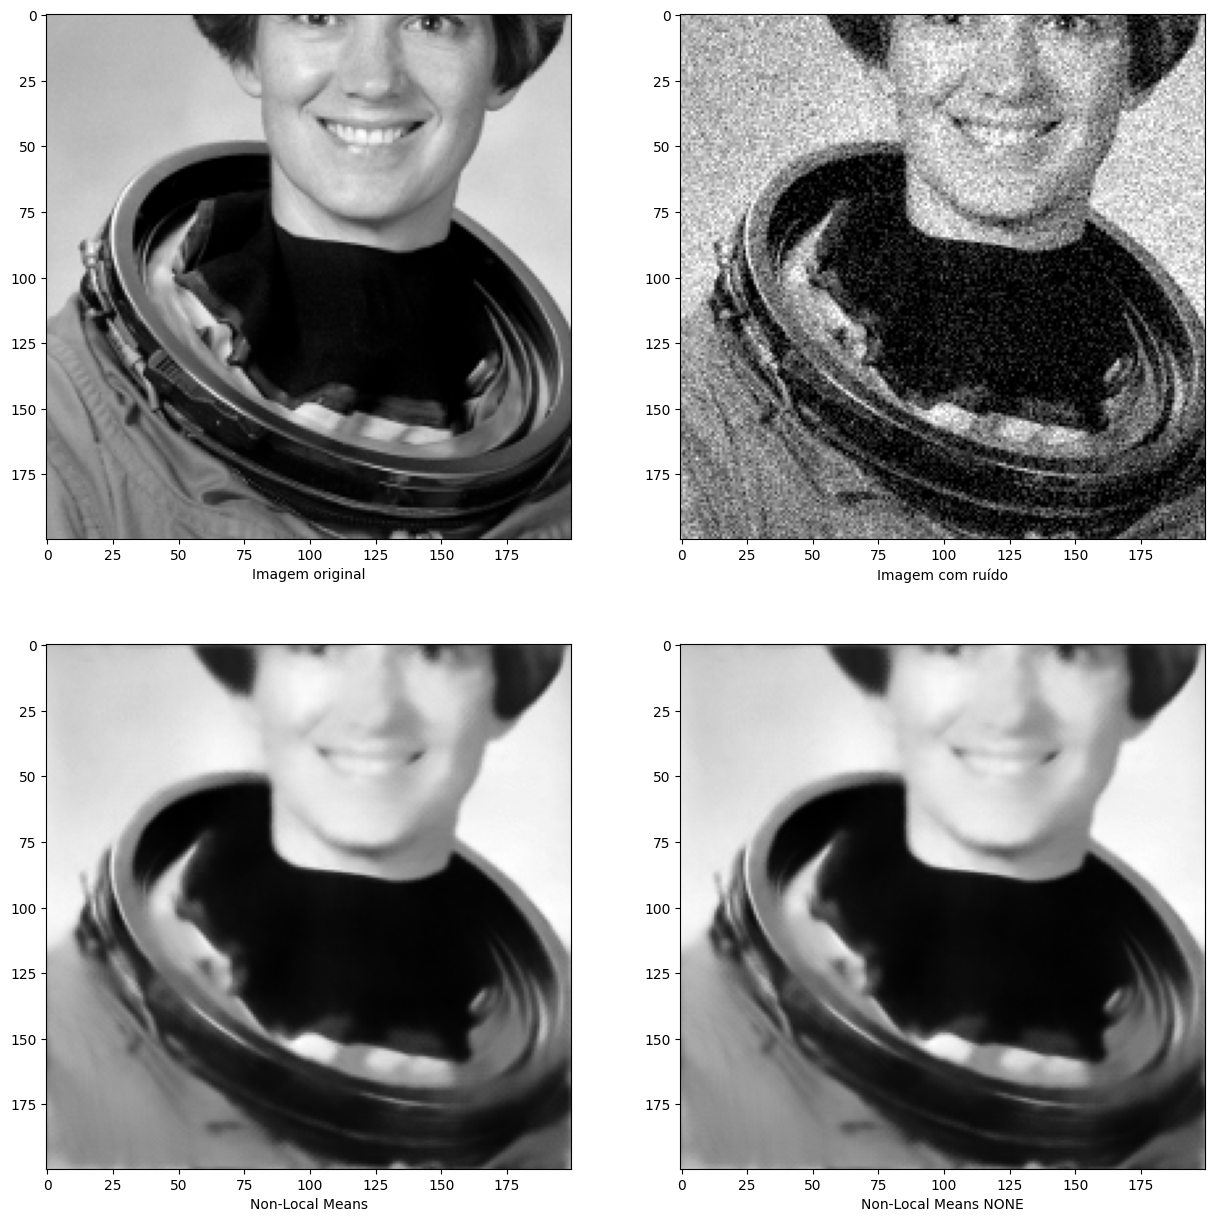

,Noise,Nlmeans,NONE Nlmeans
PSNR,20.582626,23.142633,23.142633
SSIM,0.450165,0.679699,0.679699
MSE,0.008745,0.003362,0.003362


In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

plt.subplot(2, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(2, 2, 2)
plt.xlabel('Imagem com ruído')
plt.imshow(im_nse)

plt.subplot(2, 2, 3)
plt.xlabel('Non-Local Means')
plt.imshow(im_fil1)

plt.subplot(2, 2, 4)
plt.xlabel('Non-Local Means NONE')
plt.imshow(im_fil2)
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'NONE Nlmeans'],
)

## Análise do algoritmo

### Conversão de listas do python em arrays do numpy

Todos os resultados retornados pelas funções `nlmeans`, `nlmeans_udlf` e `nlmeans_udlf_no_sort` são listas do python. A fim de facilitar a implementação da analise, a tornar a execução da mesma mais eficiente e [diminuir o uso de memória](https://stackoverflow.com/a/994010), todas as listas serão transformadas em array do numpy. 

In [12]:
diff_nlm = np.array(diff_nlm)
diff_base = np.array(diff_base)
diff_none = np.array(diff_none)
diff_patch_nlm = np.array(diff_patch_nlm)
diff_patch_base = np.array(diff_patch_base)
diff_patch_none = np.array(diff_patch_none)
weight_nlm = np.array(weight_nlm)
weight_base = np.array(weight_base)
weight_none = np.array(weight_none)
weight_id_nlm = np.array(weight_id_nlm)
weight_id_base = np.array(weight_id_base)
weight_id_none = np.array(weight_id_none)

### Imagens deslocadas

Durante a execução do algoritmo, a imagem ruídosa é deslocada varias vezes para então ser subtraida da imagem inicial. Isso é feito com o objetivo de calcular o peso simultaneamente para todos os pixels, ao invés de calcular o peso pixel a pixel como é feito no algoritmo original. 

A ideia do Non-Local Means UDLF é, baseado no peso calculado para cada pixel na imagem, gerar novas imagens deslocadas para que dessa forma seja possível gerar pesos melhores.

<Figure size 1500x1500 with 0 Axes>

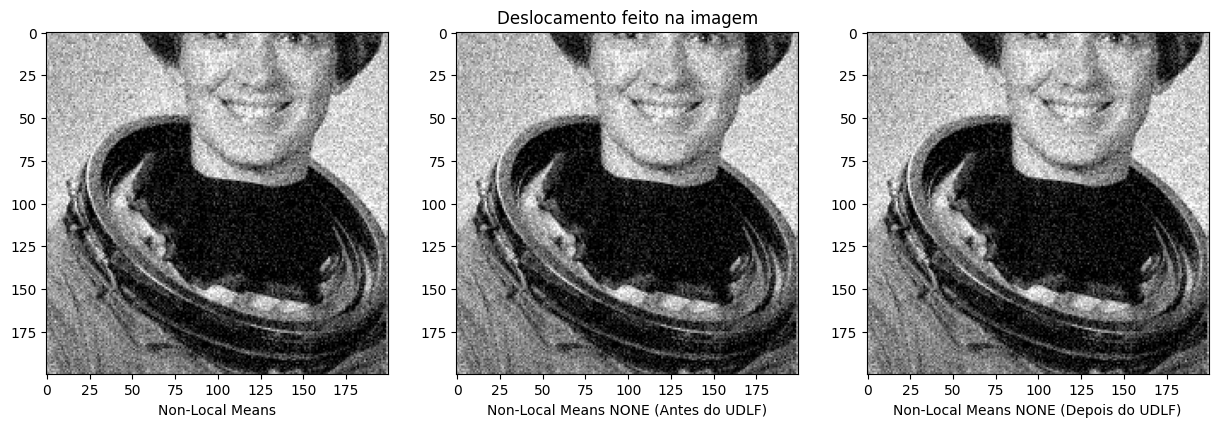

In [13]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

shift_idx = len(img_shift_nlm) // 2

plt.subplot(1, 3, 1)
plt.xlabel('Non-Local Means')
plt.imshow(img_shift_nlm[shift_idx])

plt.subplot(1, 3, 2)
plt.xlabel('Non-Local Means NONE (Antes do UDLF)')
plt.imshow(img_shift_base[shift_idx])
plt.title('Deslocamento feito na imagem')

plt.subplot(1, 3, 3)
plt.xlabel('Non-Local Means NONE (Depois do UDLF)')
plt.imshow(img_shift_none[shift_idx])

plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

In [14]:
shift_none_base = []
shift_nlm_base = []
shift_nlm_none = []
for i in range(len(img_shift_nlm)):
    shift_none_base.append((img_shift_base[i] == img_shift_none[i]).all())
    shift_nlm_base.append((img_shift_base[i] == img_shift_nlm[i]).all())
    shift_nlm_none.append((img_shift_nlm[i] == img_shift_none[i]).all())

print('Imagens deslocadas base == Imagens deslocadas NONE:', np.array(shift_none_base).all())
print('Imagens deslocadas base == Imagens deslocadas NLM: ', np.array(shift_nlm_base).all())
print('Imagens deslocadas NONE == Imagens deslocadas NLM: ', np.array(shift_nlm_none).all())

Imagens deslocadas base == Imagens deslocadas NONE: True
Imagens deslocadas base == Imagens deslocadas NLM:  True
Imagens deslocadas NONE == Imagens deslocadas NLM:  True


### Comparação de dados de cada execução

Compara os dados recolhidos ao executar o Non-Local Means e o Non-Local Means NONE. Os dadso comparados são:
- Diferença de pixels
- Diferença de patches
- Pesos
- IDs de pesos

In [15]:
diff_none_base = []
diff_nlm_none = []
diff_nlm_base = []

patch_none_base = []
patch_nlm_none = []
patch_nlm_base = []

weight_none_base = []
weight_nlm_none = []
weight_nlm_base = []

weight_id_none_base = []
weight_id_nlm_none = []
weight_id_nlm_base = []

for i in range(im_fil2.shape[0]):
    for j in range(im_fil2.shape[1]):
        diff_none_base.append(diff_base[i, j] == diff_none[i, j])
        diff_nlm_none.append(diff_nlm[i, j] == diff_none[i, j])
        diff_nlm_base.append(diff_nlm[i, j] == diff_base[i, j])

        patch_none_base.append(diff_patch_base[i, j] == diff_patch_none[i, j])
        patch_nlm_none.append(diff_patch_nlm[i, j] == diff_patch_none[i, j])
        patch_nlm_base.append(diff_patch_base[i, j] == diff_patch_nlm[i, j])

        weight_none_base.append(weight_base[i, j] == weight_none[i, j])
        weight_nlm_none.append(weight_nlm[i, j] == weight_none[i, j])
        weight_nlm_base.append(weight_base[i, j] == weight_nlm[i, j])

        weight_id_none_base.append(weight_id_base[i, j] == weight_id_none[i, j])
        weight_id_nlm_none.append(weight_id_nlm[i, j] == weight_id_none[i, j])
        weight_id_nlm_base.append(weight_id_base[i, j] == weight_id_nlm[i, j])

In [16]:
print('Diferenças entre pixels:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE',],
    columns = ['Nlmeans', 'Base', 'NONE',],
    data = [[True, np.array(diff_nlm_base).all(), np.array(diff_nlm_none).all()],
            [np.array(diff_nlm_base).all(), True, np.array(diff_none_base).all()],
            [np.array(diff_nlm_none).all(), np.array(diff_none_base).all(), True]]
)

Diferenças entre pixels:


,Nlmeans,Base,NONE
Nlmeans,True,True,True
Base,True,True,True
NONE,True,True,True


In [17]:
print('Diferenças entre patches:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE',],
    columns = ['Nlmeans', 'Base', 'NONE',],
    data = [[True, np.array(patch_nlm_base).all(), np.array(patch_nlm_none).all()],
            [np.array(patch_nlm_base).all(), True, np.array(patch_none_base).all()],
            [np.array(patch_nlm_none).all(), np.array(patch_none_base).all(), True]]
)

Diferenças entre patches:


,Nlmeans,Base,NONE
Nlmeans,True,True,True
Base,True,True,True
NONE,True,True,True


In [18]:
print('Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE',],
    columns = ['Nlmeans', 'Base', 'NONE',],
    data = [[True, np.array(weight_nlm_base).all(), np.array(weight_nlm_none).all()],
            [np.array(weight_nlm_base).all(), True, np.array(weight_none_base).all()],
            [np.array(weight_nlm_none).all(), np.array(weight_none_base).all(), True]]
)

Pesos:


,Nlmeans,Base,NONE
Nlmeans,True,True,True
Base,True,True,True
NONE,True,True,True


In [19]:
print('IDs de Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE',],
    columns = ['Nlmeans', 'Base', 'NONE',],
    data = [[True, np.array(weight_id_nlm_base).all(), np.array(weight_id_nlm_none).all()],
            [np.array(weight_id_nlm_base).all(), True, np.array(weight_id_none_base).all()],
            [ np.array(weight_id_nlm_none).all(), np.array(weight_id_none_base).all(), True]]
)

IDs de Pesos:


,Nlmeans,Base,NONE
Nlmeans,True,True,True
Base,True,True,True
NONE,True,True,True


### Comparação das imagens resultantes

In [11]:
print((im_fil_base == im_fil1).all())
print((im_fil_base == im_fil2).all())
print((im_fil1 == im_fil2).all())

True
True
True


# Hipótese 1

Utilizando o método UDLF NONE, os pixels dentro de cada área de busca permanecem os mesmos (uma vez que o método UDLF NONE apenas retorna as listas ranqueadas que ele recebeu e que por vez, são os pixels de cada área de busca apenas reordenados para que fiquem em ordem decrescente de peso) porém, a reordenação desses pixels muda os patches, o que faz com que o peso atribuido a um pixel seja diferente uma vez que sua vizinhança mudou.

## Parametros

In [22]:
# UDLF Method parameters
udl_method = 'CPRR'
udl_params = get_udl_params(udl_method)
print(udl_params)

{'k': 3, 't': 1}


## Execução do código
Execução do código como um todo: aquisição da imagem, processamento da imagem, execução do Non-Local Means e Non-Local Means NONE UDLF

In [23]:
# Utilizando a mesma imagem base e com ruído do teste anterior
# im, im_name = get_image(image)
# im, im_nse, sigma_est = process_image(im, cut_shape)

In [24]:
%%time
results = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
im_fil1        = results[0]
diff_nlm       = results[1]
diff_patch_nlm = results[2]
weight_nlm     = results[3]
weight_id_nlm  = results[4]
img_shift_nlm  = results[5]

CPU times: user 1.82 s, sys: 100 ms, total: 1.92 s
Wall time: 1.92 s


In [25]:
%%time
results = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
im_fil2         = results[0]
diff_base       = results[1]
diff_none       = results[2]
diff_patch_base = results[3]
diff_patch_none = results[4]
weight_base     = results[5]
weight_none     = results[6]
weight_id_base  = results[7]
weight_id_none  = results[8]
img_shift_base  = results[9]
img_shift_none  = results[10]

CPU times: user 15.4 s, sys: 754 ms, total: 16.2 s
Wall time: 16.2 s


In [26]:
%%time
results = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
im_fil3         = results[0]
diff_udlf       = results[2]
diff_patch_udlf = results[4]
weight_udlf     = results[6]
weight_id_udlf  = results[8]
img_shift_udlf  = results[10]
rm_tmp_files()

CPU times: user 16.9 s, sys: 1.59 s, total: 18.5 s
Wall time: 32.6 s


<Figure size 1500x1500 with 0 Axes>

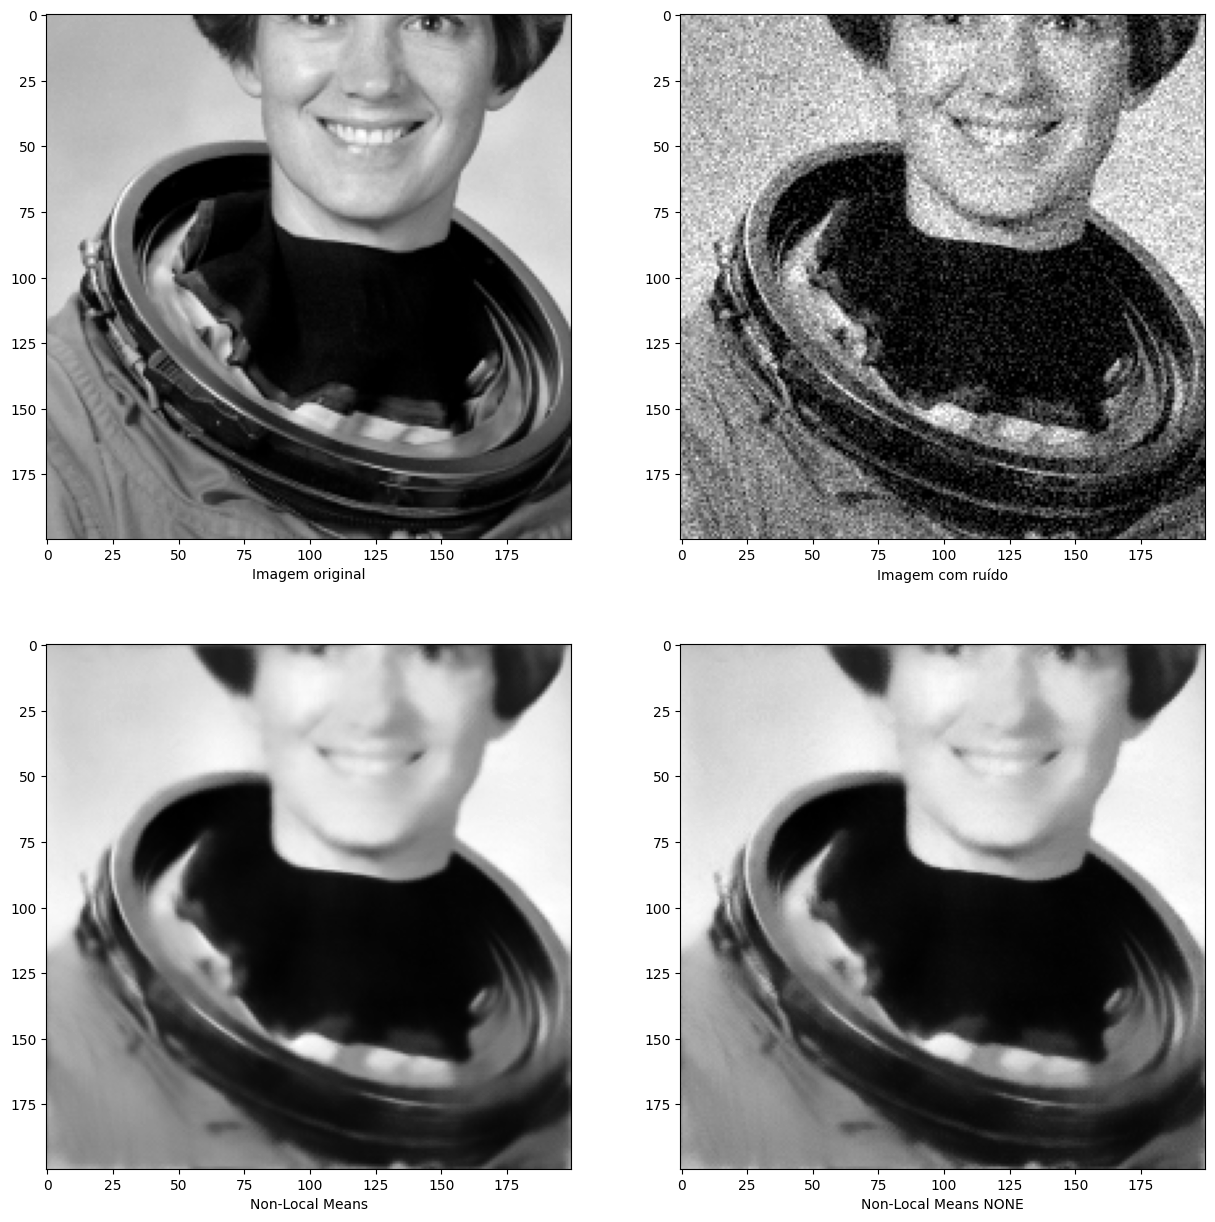

,Noise,Nlmeans,NONE Nlmeans,CPRR Nlmeans
PSNR,20.582626,23.142633,23.327438,22.879415
SSIM,0.450165,0.679699,0.687343,0.673141
MSE,0.008745,0.003362,0.003233,0.003598


In [27]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

plt.subplot(2, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(2, 2, 2)
plt.xlabel('Imagem com ruído')
plt.imshow(im_nse)

plt.subplot(2, 2, 3)
plt.xlabel('Non-Local Means')
plt.imshow(im_fil1)

plt.subplot(2, 2, 4)
plt.xlabel('Non-Local Means NONE')
plt.imshow(im_fil2)
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil2)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil3)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_none_psnr, im_udlf_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_none_ssim, im_udlf_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_none_mse,  im_udlf_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'NONE Nlmeans', f'{udl_method} Nlmeans'],
)

## Análise do algoritmo

### Conversão de listas do python em arrays do numpy

In [28]:
diff_nlm = np.array(diff_nlm)
diff_base = np.array(diff_base)
diff_none = np.array(diff_none)
diff_udlf = np.array(diff_udlf)
diff_patch_nlm = np.array(diff_patch_nlm)
diff_patch_base = np.array(diff_patch_base)
diff_patch_none = np.array(diff_patch_none)
diff_patch_udlf = np.array(diff_patch_udlf)
weight_nlm = np.array(weight_nlm)
weight_base = np.array(weight_base)
weight_none = np.array(weight_none)
weight_udlf = np.array(weight_udlf)
weight_id_nlm = np.array(weight_id_nlm)
weight_id_base = np.array(weight_id_base)
weight_id_none = np.array(weight_id_none)
weight_id_udlf = np.array(weight_id_udlf)

### Imagens deslocadas

Durante a execução do algoritmo, a imagem ruídosa é deslocada varias vezes para então ser subtraida da imagem inicial. Isso é feito com o objetivo de calcular o peso simultaneamente para todos os pixels, ao invés de calcular o peso pixel a pixel como é feito no algoritmo original. 

A ideia do Non-Local Means UDLF é, baseado no peso calculado para cada pixel na imagem, gerar novas imagens deslocadas para que dessa forma seja possível gerar pesos melhores.

<Figure size 1500x1500 with 0 Axes>

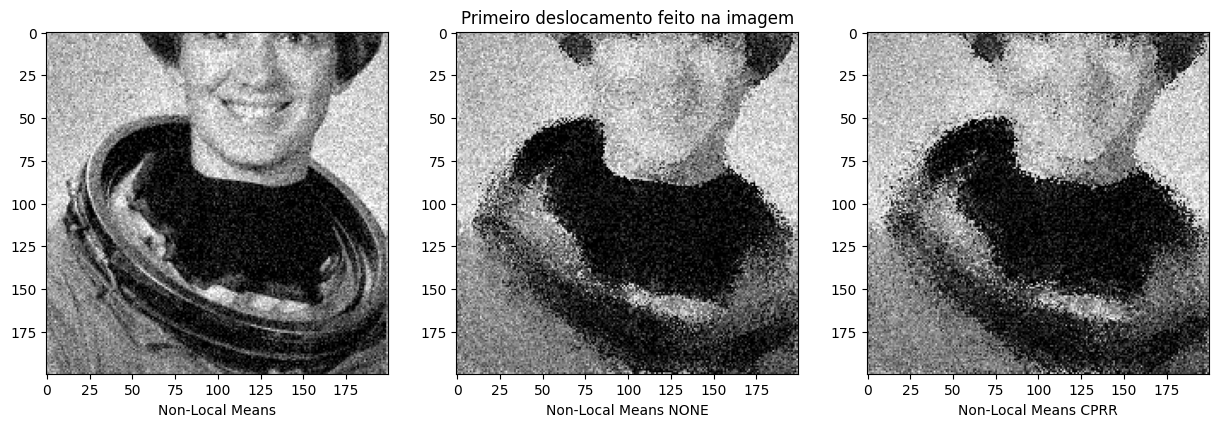

In [29]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

shift_idx = len(img_shift_nlm) // 2

plt.subplot(1, 3, 1)
plt.xlabel('Non-Local Means')
plt.imshow(img_shift_nlm[shift_idx])

plt.subplot(1, 3, 2)
plt.xlabel('Non-Local Means NONE')
plt.imshow(img_shift_none[shift_idx])
plt.title('Primeiro deslocamento feito na imagem')

plt.subplot(1, 3, 3)
plt.xlabel(f'Non-Local Means {udl_method}')
plt.imshow(img_shift_udlf[shift_idx])

plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

Mesmo com a mudança de posição entre os pixels, o conjunto das diferenças dos pixels dentro de uma área de busca devem ser iguais. Uma simples visualização dos dados mostra que isso é verdadeiro.

In [30]:
# Save all shift images
# OUT_DIR = 'debug/img_shift'
# for i in range(len(img_shift_nlm)):
    # plt.imsave(f'{OUT_DIR}/nlm/img{i}.png', img_shift_nlm[i])
    # plt.imsave(f'{OUT_DIR}/none/img{i}.png', img_shift_none[i])
    # plt.imsave(f'{OUT_DIR}/udlf/img{i}.png', img_shift_udlf[i])

### Comparação de dados de cada execução

Nesse etapa foram comparados dados retirados de cada execução, sendo eles
- Diferença entre pixels
- Diferenças entre patches
- Pesos
- IDs de pesos

In [31]:
diff_nlm_base    = []
diff_nlm_none    = []
diff_nlm_udlf    = []
diff_none_base   = []
diff_none_udlf   = []
diff_udlf_base   = []

patch_nlm_base   = []
patch_nlm_none   = []
patch_nlm_udlf   = []
patch_none_base  = []
patch_none_udlf  = []
patch_udlf_base  = []

weight_nlm_base  = []
weight_nlm_none  = []
weight_nlm_udlf  = []
weight_none_base = []
weight_none_udlf = []
weight_udlf_base = []

weight_id_nlm_base  = []
weight_id_nlm_none  = []
weight_id_nlm_udlf  = []
weight_id_none_base = []
weight_id_none_udlf = []
weight_id_udlf_base = []

for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        diff_nlm_base.append((diff_nlm[i, j] == diff_base[i, j]))
        diff_nlm_none.append((diff_nlm[i, j] == diff_none[i, j]))
        diff_nlm_udlf.append((diff_nlm[i, j] == diff_udlf[i, j]))
        diff_none_base.append((diff_none[i, j] == diff_base[i, j]))
        diff_none_udlf.append((diff_none[i, j] == diff_udlf[i, j]))
        diff_udlf_base.append((diff_udlf[i, j] == diff_base[i, j]))
        
        patch_nlm_base.append((diff_patch_nlm[i, j] == diff_patch_base[i, j]))
        patch_nlm_none.append((diff_patch_nlm[i, j] == diff_patch_none[i, j]))
        patch_nlm_udlf.append((diff_patch_nlm[i, j] == diff_patch_udlf[i, j]))
        patch_none_base.append((diff_patch_none[i, j] == diff_patch_base[i, j]))
        patch_none_udlf.append((diff_patch_none[i, j] == diff_patch_udlf[i, j]))
        patch_udlf_base.append((diff_patch_udlf[i, j] == diff_patch_base[i, j]))

        weight_nlm_base.append((weight_nlm[i, j] == weight_base[i, j]))
        weight_nlm_none.append((weight_nlm[i, j] == weight_none[i, j]))
        weight_nlm_udlf.append((weight_nlm[i, j] == weight_udlf[i, j]))
        weight_none_base.append((weight_none[i, j] == weight_base[i, j]))
        weight_none_udlf.append((weight_none[i, j] == weight_udlf[i, j]))
        weight_udlf_base.append((weight_udlf[i, j] == weight_base[i, j]))

        weight_id_nlm_base.append((weight_id_nlm[i, j] == weight_id_base[i, j]))
        weight_id_nlm_none.append((weight_id_nlm[i, j] == weight_id_none[i, j]))
        weight_id_nlm_udlf.append((weight_id_nlm[i, j] == weight_id_udlf[i, j]))
        weight_id_none_base.append((weight_id_none[i, j] == weight_id_base[i, j]))
        weight_id_none_udlf.append((weight_id_none[i, j] == weight_id_udlf[i, j]))
        weight_id_udlf_base.append((weight_id_udlf[i, j] == weight_id_base[i, j]))

In [32]:
print('Diferenças entre pixels:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(diff_nlm_base).all(), np.array(diff_nlm_none).all(), np.array(diff_nlm_udlf).all()],
            [np.array(diff_nlm_base).all(), True, np.array(diff_none_base).all(), np.array(diff_udlf_base).all()],
            [np.array(diff_nlm_none).all(), np.array(diff_none_base).all(), True, np.array(diff_none_udlf).all()],
            [np.array(diff_nlm_udlf).all(), np.array(diff_udlf_base).all(), np.array(diff_none_udlf).all(), True]]
)

Diferenças entre pixels:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [33]:
print('Diferença entre patches:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(patch_nlm_base).all(), np.array(patch_nlm_none).all(), np.array(patch_nlm_udlf).all()],
            [np.array(patch_nlm_base).all(), True, np.array(patch_none_base).all(), np.array(patch_udlf_base).all()],
            [np.array(patch_nlm_none).all(), np.array(patch_none_base).all(), True, np.array(patch_none_udlf).all()],
            [np.array(patch_nlm_udlf).all(), np.array(patch_udlf_base).all(), np.array(patch_none_udlf).all(), True]]
)

Diferença entre patches:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [34]:
print('Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(weight_nlm_base).all(), np.array(weight_nlm_none).all(), np.array(weight_nlm_udlf).all()],
            [np.array(weight_nlm_base).all(), True, np.array(weight_none_base).all(), np.array(weight_udlf_base).all()],
            [np.array(weight_nlm_none).all(), np.array(weight_none_base).all(), True, np.array(weight_none_udlf).all()],
            [np.array(weight_nlm_udlf).all(), np.array(weight_udlf_base).all(), np.array(weight_none_udlf).all(), True]]
)

Pesos:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [35]:
print('IDs de Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(weight_id_nlm_base).all(), np.array(weight_id_nlm_none).all(), np.array(weight_id_nlm_udlf).all()],
            [np.array(weight_id_nlm_base).all(), True, np.array(weight_id_none_base).all(), np.array(weight_id_udlf_base).all()],
            [np.array(weight_id_nlm_none).all(), np.array(weight_id_none_base).all(), True, np.array(weight_id_none_udlf).all()],
            [np.array(weight_id_nlm_udlf).all(), np.array(weight_id_udlf_base).all(), np.array(weight_id_none_udlf).all(), True]]
)

IDs de Pesos:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


#### Versão ordenada

In [36]:
diff_nlm = np.sort(diff_nlm)
diff_base = np.sort(diff_base)
diff_none = np.sort(diff_none)
diff_udlf = np.sort(diff_udlf)
diff_patch_nlm = np.sort(diff_patch_nlm)
diff_patch_base = np.sort(diff_patch_base)
diff_patch_none = np.sort(diff_patch_none)
diff_patch_udlf = np.sort(diff_patch_udlf)
weight_nlm = np.sort(weight_nlm)
weight_base = np.sort(weight_base)
weight_none = np.sort(weight_none)
weight_udlf = np.sort(weight_udlf)
weight_id_nlm = np.sort(weight_id_nlm)
weight_id_base = np.sort(weight_id_base)
weight_id_none = np.sort(weight_id_none)
weight_id_udlf = np.sort(weight_id_udlf)

In [37]:
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        diff_nlm_base.append((diff_nlm[i, j] == diff_base[i, j]))
        diff_nlm_none.append((diff_nlm[i, j] == diff_none[i, j]))
        diff_nlm_udlf.append((diff_nlm[i, j] == diff_udlf[i, j]))
        diff_none_base.append((diff_none[i, j] == diff_base[i, j]))
        diff_none_udlf.append((diff_none[i, j] == diff_udlf[i, j]))
        diff_udlf_base.append((diff_udlf[i, j] == diff_base[i, j]))
        
        patch_nlm_base.append((diff_patch_nlm[i, j] == diff_patch_base[i, j]))
        patch_nlm_none.append((diff_patch_nlm[i, j] == diff_patch_none[i, j]))
        patch_nlm_udlf.append((diff_patch_nlm[i, j] == diff_patch_udlf[i, j]))
        patch_none_base.append((diff_patch_none[i, j] == diff_patch_base[i, j]))
        patch_none_udlf.append((diff_patch_none[i, j] == diff_patch_udlf[i, j]))
        patch_udlf_base.append((diff_patch_udlf[i, j] == diff_patch_base[i, j]))

        weight_nlm_base.append((weight_nlm[i, j] == weight_base[i, j]))
        weight_nlm_none.append((weight_nlm[i, j] == weight_none[i, j]))
        weight_nlm_udlf.append((weight_nlm[i, j] == weight_udlf[i, j]))
        weight_none_base.append((weight_none[i, j] == weight_base[i, j]))
        weight_none_udlf.append((weight_none[i, j] == weight_udlf[i, j]))
        weight_udlf_base.append((weight_udlf[i, j] == weight_base[i, j]))
        
        weight_id_nlm_base.append((weight_id_nlm[i, j] == weight_id_base[i, j]))
        weight_id_nlm_none.append((weight_id_nlm[i, j] == weight_id_none[i, j]))
        weight_id_nlm_udlf.append((weight_id_nlm[i, j] == weight_id_udlf[i, j]))
        weight_id_none_base.append((weight_id_none[i, j] == weight_id_base[i, j]))
        weight_id_none_udlf.append((weight_id_none[i, j] == weight_id_udlf[i, j]))
        weight_id_udlf_base.append((weight_id_udlf[i, j] == weight_id_base[i, j]))

In [38]:
print('Diferenças entre pixels:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(diff_nlm_base).all(), np.array(diff_nlm_none).all(), np.array(diff_nlm_udlf).all()],
            [np.array(diff_nlm_base).all(), True, np.array(diff_none_base).all(), np.array(diff_udlf_base).all()],
            [np.array(diff_nlm_none).all(), np.array(diff_none_base).all(), True, np.array(diff_none_udlf).all()],
            [np.array(diff_nlm_udlf).all(), np.array(diff_udlf_base).all(), np.array(diff_none_udlf).all(), True]]
)

Diferenças entre pixels:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [39]:
print('Diferença entre patches:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(patch_nlm_base).all(), np.array(patch_nlm_none).all(), np.array(patch_nlm_udlf).all()],
            [np.array(patch_nlm_base).all(), True, np.array(patch_none_base).all(), np.array(patch_udlf_base).all()],
            [np.array(patch_nlm_none).all(), np.array(patch_none_base).all(), True, np.array(patch_none_udlf).all()],
            [np.array(patch_nlm_udlf).all(), np.array(patch_udlf_base).all(), np.array(patch_none_udlf).all(), True]]
)

Diferença entre patches:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [40]:
print('Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(weight_nlm_base).all(), np.array(weight_nlm_none).all(), np.array(weight_nlm_udlf).all()],
            [np.array(weight_nlm_base).all(), True, np.array(weight_none_base).all(), np.array(weight_udlf_base).all()],
            [np.array(weight_nlm_none).all(), np.array(weight_none_base).all(), True, np.array(weight_none_udlf).all()],
            [np.array(weight_nlm_udlf).all(), np.array(weight_udlf_base).all(), np.array(weight_none_udlf).all(), True]]
)

Pesos:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True


In [41]:
print('IDs de Pesos:')
pd.DataFrame(
    index = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    columns = ['Nlmeans', 'Base', 'NONE', 'UDLF'],
    data = [[True, np.array(weight_id_nlm_base).all(), np.array(weight_id_nlm_none).all(), np.array(weight_id_nlm_udlf).all()],
            [np.array(weight_id_nlm_base).all(), True, np.array(weight_id_none_base).all(), np.array(weight_id_udlf_base).all()],
            [np.array(weight_id_nlm_none).all(), np.array(weight_id_none_base).all(), True, np.array(weight_id_none_udlf).all()],
            [np.array(weight_id_nlm_udlf).all(), np.array(weight_id_udlf_base).all(), np.array(weight_id_none_udlf).all(), True]]
)

IDs de Pesos:


,Nlmeans,Base,NONE,UDLF
Nlmeans,True,True,False,False
Base,True,True,False,False
NONE,False,False,True,False
UDLF,False,False,False,True
